In [1]:
import os
import time
import logging

import keras
import openai
import dotenv
import bentoml
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt

from keras import layers
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix


# Create a logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a console handler and set the log level
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)

# Create a formatter and set it to the console handler
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)

# Add the console handler to the logger
logger.addHandler(console_handler)

2024-05-21 07:19:41.046286: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
OPENAI_EMBEDDING_MODEL = "text-embedding-3-large"
DATA_FILES_ROOT = "../dataset/data/"
CONVERSATIONS_CSV_PATH = os.path.join(DATA_FILES_ROOT, "conversations.csv")
EMBEDDINGS_CACHE_PATH = os.path.join(DATA_FILES_ROOT, "vectors.npy")

dotenv.load_dotenv()
client = openai.OpenAI()

# Load Data

In [3]:
raw_df = pd.read_csv(CONVERSATIONS_CSV_PATH)[["message", "message_type"]]
raw_df.rename(columns={
    "message": "text", 
    "message_type": "label"
}, inplace=True)
raw_df.head()

,text,label
0,"Hey guys, I'm having trouble with my linear re...",Question
1,What's your data look like? Are you using any ...,Comment
2,I'm using a dataset with 1000 samples and 10 f...,Answer
3,Have you checked for multicollinearity? Maybe ...,Comment
4,"Yeah, I did check for multicollinearity and re...",Answer


# Clean Data

In [4]:
raw_df['label'].value_counts()

label
Answer          605
Question        547
Comment         261
question         20
answer           19
comment           8
Response          5
Advice            3
Spam              2
Resource          1
Suggestion        1
Appreciation      1
Name: count, dtype: int64

In [5]:
allowed_labels = {'question', 'answer', 'comment'}
raw_df['label'] = raw_df['label'].str.lower()
raw_df = raw_df[raw_df['label'].isin(allowed_labels)]
raw_df['label'].value_counts()

label
answer      624
question    567
comment     269
Name: count, dtype: int64

# Embed Data

In [ ]:
vectors = []

number_of_samples = len(raw_df)

for idx, text in enumerate(raw_df['text']):
    print(f"{idx}/{number_of_samples} - {text}")
    try:
        response = client.embeddings.create(
            input=text,
            model=OPENAI_EMBEDDING_MODEL,
        )
        vector = response.data[0].embedding
        vectors.append(vector)
    except openai.APIError:
        logger.error(f"Failed to embed text: {text}")
        time.sleep(5)
        continue
    except openai.error.ServiceUnavailableError:
        logger.error("OpenAI Service is unavailable")
        break
    
vectors_arr = np.asarray(vectors, dtype=np.float64)
np.save(EMBEDDINGS_CACHE_PATH, vectors_arr)

# Train-test Split

In [6]:
def label_encoder(label):
    return {
        "question": 0,
        "answer": 1,
        "comment": 2
    }[label]

vectors_arr = np.load(EMBEDDINGS_CACHE_PATH)
df_full = raw_df.copy()
df_full['label'] = raw_df['label']
df_full['label_id'] = df_full['label'].apply(label_encoder)
df_full['vector'] = list(vectors_arr)

train_size = 0.8

df_train = df_full.sample(frac=train_size, random_state=42)
df_test = df_full.drop(df_train.index).reset_index(drop=True)

df_train.head()

,text,label,label_id,vector
894,"Hi! Yeah, I'd be happy to help. K-means is a t...",answer,1,"[-0.012134386226534843, -9.189688717015088e-05..."
1109,"Data analysts usually need strong SQL, spreads...",answer,1,"[0.0025824133772403, -0.022944526746869087, -0..."
413,"Awesome, thanks so much! I'll definitely look ...",comment,2,"[0.022549433633685112, 0.03613811731338501, -0..."
524,"Hey everyone, I'm just starting to learn about...",question,0,"[0.0012090475065633655, 0.02343117631971836, -..."
1039,"Awesome, thanks for the tips! I'll make sure t...",question,0,"[0.012299810536205769, 0.01986454799771309, -0..."


# Define Model

In [7]:
embedding_size = len(df_train['vector'].iloc[0])
num_classes = len(df_full['label'].unique())
input_layer = keras.Input((embedding_size, ))
hidden_layer = layers.Dense(embedding_size, activation='relu')(input_layer)
output_layer = layers.Dense(num_classes, activation='softmax')(hidden_layer)
classifier = keras.Model(
    inputs=[
        input_layer
    ],
    outputs=output_layer,
)
classifier.summary()

classifier.compile(
    # loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3072)           │     9,440,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         9,219 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,449,475 (36.05 MB)

 Trainable params: 9,449,475 (36.05 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [8]:
NUM_EPOCHS = 40
BATCH_SIZE = 32

# Split the x and y components of the train and validation subsets.
y_train = df_train['label_id']
x_train = np.stack(df_train['vector'])
y_test = df_test['label_id']
x_test = np.stack(df_test['vector'])

# Train the model for the desired number of epochs.
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

class_counts = df_train['label_id'].value_counts()
total_count = class_counts.sum()
class_weight = {
    label: round(total_count / count, 4)
    for label, count in class_counts.items()
}
print("Class Weights: ", class_weight)

history = classifier.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    callbacks=[callback],
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    # class_weight=class_weight,
)


Class Weights:  {1: 2.3407, 0: 2.6013, 2: 5.3091}
Epoch 1/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.7474 - loss: 0.6372 - val_accuracy: 0.9178 - val_loss: 0.2700
Epoch 2/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9505 - loss: 0.1425 - val_accuracy: 0.9178 - val_loss: 0.2374
Epoch 3/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9769 - loss: 0.0764 - val_accuracy: 0.9178 - val_loss: 0.2348
Epoch 4/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9862 - loss: 0.0518 - val_accuracy: 0.9110 - val_loss: 0.2460
Epoch 5/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9893 - loss: 0.0373 - val_accuracy: 0.9212 - val_loss: 0.2572
Epoch 6/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9921 - loss: 0.0310 - val_accuracy: 0.9212 - val_loss: 0.2770
Epoch 7/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9995 - loss: 0.0093 - val_accuracy: 0.9315 - val_loss: 0.2798
Epoch 8/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - 

# Evaluate Model

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
F1 Score: 91.68%
Accuracy: 91.78%
Recall: 91.78%


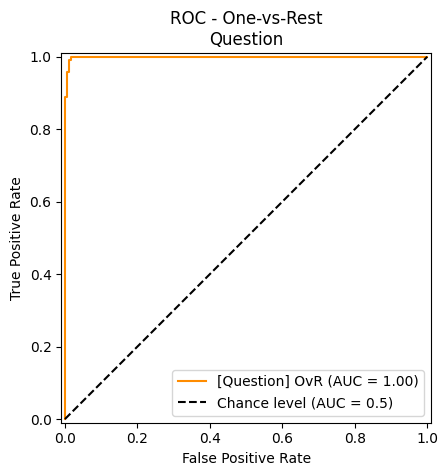

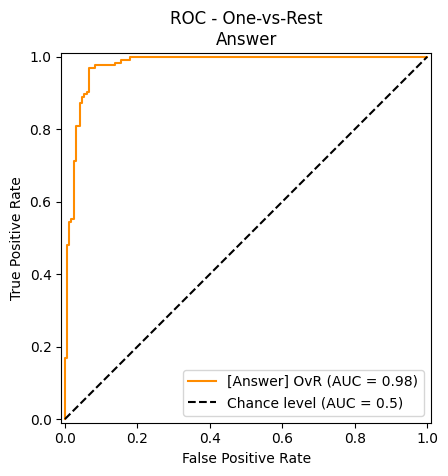

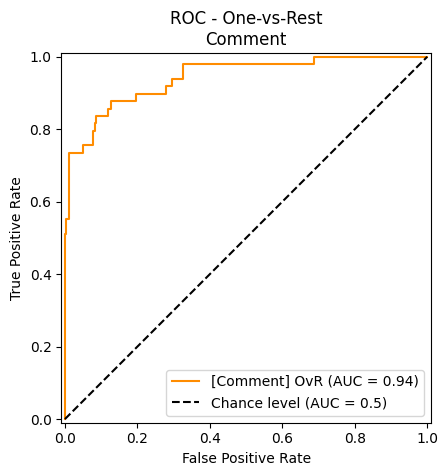

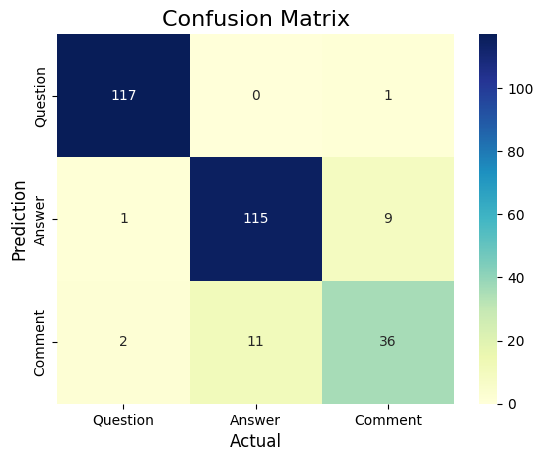

In [9]:
test_x = np.stack(df_test['vector'])
test_y = df_test['label_id']
test_y_hat = classifier.predict(test_x)


def print_stats(y, y_hat, labels):
    f1_score = sklearn.metrics.f1_score(y, np.argmax(y_hat, axis=1), average='weighted')
    accuracy = sklearn.metrics.accuracy_score(y, np.argmax(y_hat, axis=1))
    recall = sklearn.metrics.recall_score(y, np.argmax(y_hat, axis=1), average='weighted')
    
    print(f"F1 Score: {f1_score * 100:.2f}%")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")

def show_roc(y, y_hat, name):
    display = RocCurveDisplay.from_predictions(
        y,
        y_hat,
        name=f"[{name}] OvR",
        color="darkorange",
        plot_chance_level=True,
    )
    display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"ROC - One-vs-Rest\n{name}",
    )
    plt.show()
    
    
def show_confusion_matrix(y, y_hat, labels):
    cm = confusion_matrix(y, y_hat)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Prediction', fontsize=12)
    plt.xlabel('Actual', fontsize=12)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()


labels = ['Question', 'Answer', 'Comment']
print_stats(test_y, test_y_hat, labels)
show_roc(test_y == 0, test_y_hat[::, 0], "Question")
show_roc(test_y == 1, test_y_hat[::, 1], "Answer")
show_roc(test_y == 2, test_y_hat[::, 2], "Comment")
show_confusion_matrix(test_y, np.argmax(test_y_hat, axis=1), labels)


# Manual Evaluation

In [54]:
text = "How do I install a package in Python?"

client = openai.OpenAI()
vector = client.embeddings.create(
    input=text,
    model=OPENAI_EMBEDDING_MODEL,
).data[0].embedding

vector = np.asarray(vector, dtype=np.float64)

y_hat = classifier.predict(x=vector.reshape(1, -1))
y_hat_max = np.argmax(y_hat, axis=1)[0]

label = {
    0: "Question",
    1: "Answer",
    2: "Comment",
}[y_hat_max]

print(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Question


# Export Model

In [26]:
bento_model = bentoml.tensorflow.save_model("qa_classifier", classifier)

INFO:tensorflow:Assets written to: /var/folders/t5/3qb7sc1j15n13hjcgf4d857h0000gn/T/tmpny827sqgbentoml_model_qa_classifier/assets


INFO:tensorflow:Assets written to: /var/folders/t5/3qb7sc1j15n13hjcgf4d857h0000gn/T/tmpny827sqgbentoml_model_qa_classifier/assets
